In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd    #89, 91, 92
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
dataset=pd.read_csv('nuovo_dataset_totale.csv')

In [3]:
dataset

,Unnamed: 0,id,name,disc_number,duration_ms,explicit,popularity,track_number,artists,album_type,...,valence,tempo,time_signature,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_bars,genre,popularity_artist
0,0,4rjA5kJJWbwU1prXCvg6Fk,Grey,1.0,290.48,False,52.0,5.0,Kölsch,album,...,0.24,186.00,3.0,0.02,1.00,0.50,0.52,234.0,minimal-techno,[51.0]
1,1,6xzpUzzIquIyUzTLbbgSdI,Thrown,1.0,539.23,False,45.0,5.0,Kiasmos,album,...,0.14,120.02,4.0,0.68,0.33,0.41,0.59,269.0,minimal-techno,[47.0]
2,2,56tXgHlSHCfgmGhwVXNizc,Routine,1.0,264.20,False,39.0,5.0,Joris Delacroix,album,...,0.32,118.05,3.0,0.85,0.46,0.90,0.76,171.0,minimal-techno,[44.0]
3,3,0s3wIBczp6TdSJ2y8cveJl,Confronted - Anfisa Letyago Stranger Remix,1.0,387.41,False,0.0,6.0,Pan-Pot;Anfisa Letyago,single,...,0.04,128.99,4.0,0.88,0.50,0.51,0.50,207.0,minimal-techno,"[36.0, 40.0]"
4,4,4PSbDDd1LRYMhqPXvza6I2,Jupiter Sunrise,1.0,248.96,False,0.0,1.0,Kollektiv Turmstrasse,compilation,...,0.12,120.00,4.0,0.88,1.00,0.47,0.46,123.0,minimal-techno,[45.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109144,109542,0wiDjWz3U1WfwXSrWHXe2b,I'm Good (Blue) - REAPER Extended Remix,1.0,209.66,True,23.0,2.0,David Guetta;Bebe Rexha;REAPER,single,...,0.37,173.96,4.0,0.73,1.00,0.09,0.18,145.0,edm,"[86.0, 79.0, 50.0]"
109145,109543,46n9OJc7LOIVdj8t2l5WA5,End Of The Night,1.0,205.72,True,56.0,1.0,Danny Avila,single,...,0.31,99.97,4.0,0.71,1.00,0.40,0.54,84.0,edm,[47.0]
109146,109544,127uq83uGFapbddqiMUKky,Sexy Bitch (feat. Akon),1.0,195.85,True,80.0,3.0,David Guetta;Akon,album,...,0.80,130.01,4.0,0.81,0.99,0.10,0.33,106.0,edm,"[86.0, 79.0]"
109147,109545,0ZdUHFxifUJNqo7G4aJzoF,Savannah,1.0,208.70,False,60.0,1.0,Diviners;Philly K.,single,...,0.39,108.07,4.0,0.65,1.00,0.55,0.60,89.0,edm,"[47.0, 38.0]"


In [4]:
import pandas as pd

# Assuming your dataset is in a DataFrame called df

# Define the list of genres
genres_to_filter = ['sertanejo', 'folk', 'j-idol', 'world-music', 'songwriter',
                    'progressive-house', 'heavy-metal', 'mpb', 'opera', 'minimal-techno',
                    'new-age', 'sleep', 'emo', 'kids', 'honky-tonk', 'synth-pop',
                    'goth', 'happy', 'salsa', 'piano']

# Filter the dataset based on the 'genre' column
filtered_df = dataset[dataset['genre'].isin(genres_to_filter)]

# Now, filtered_df contains only the rows where the 'genre' column matches the specified genres


In [5]:
filtered_df

,Unnamed: 0,id,name,disc_number,duration_ms,explicit,popularity,track_number,artists,album_type,...,valence,tempo,time_signature,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_bars,genre,popularity_artist
0,0,4rjA5kJJWbwU1prXCvg6Fk,Grey,1.0,290.48,False,52.0,5.0,Kölsch,album,...,0.24,186.00,3.0,0.02,1.00,0.50,0.52,234.0,minimal-techno,[51.0]
1,1,6xzpUzzIquIyUzTLbbgSdI,Thrown,1.0,539.23,False,45.0,5.0,Kiasmos,album,...,0.14,120.02,4.0,0.68,0.33,0.41,0.59,269.0,minimal-techno,[47.0]
2,2,56tXgHlSHCfgmGhwVXNizc,Routine,1.0,264.20,False,39.0,5.0,Joris Delacroix,album,...,0.32,118.05,3.0,0.85,0.46,0.90,0.76,171.0,minimal-techno,[44.0]
3,3,0s3wIBczp6TdSJ2y8cveJl,Confronted - Anfisa Letyago Stranger Remix,1.0,387.41,False,0.0,6.0,Pan-Pot;Anfisa Letyago,single,...,0.04,128.99,4.0,0.88,0.50,0.51,0.50,207.0,minimal-techno,"[36.0, 40.0]"
4,4,4PSbDDd1LRYMhqPXvza6I2,Jupiter Sunrise,1.0,248.96,False,0.0,1.0,Kollektiv Turmstrasse,compilation,...,0.12,120.00,4.0,0.88,1.00,0.47,0.46,123.0,minimal-techno,[45.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99492,99890,2jw9uRjSU1yGjMv3YMhbho,Draw A Crowd,1.0,254.35,False,30.0,6.0,Ben Folds Five,album,...,0.68,112.21,4.0,0.84,1.00,0.43,0.57,117.0,piano,[43.0]
99493,99891,3np71XMsjRnFTol0XTEgOZ,Father in Heaven,2.0,147.63,False,29.0,8.0,Paul Cardall,album,...,0.04,76.49,4.0,0.28,0.11,0.55,0.66,46.0,piano,[48.0]
99494,99892,4VA8Z5k2hd4RkBTlJFPPyd,Baby Lullaby,1.0,188.00,False,30.0,11.0,Piano Peace,album,...,0.14,69.49,5.0,0.26,0.62,0.85,0.87,78.0,piano,[61.0]
99495,99893,7xJEyMvEa3eeP1fN3E18PI,Young Man's Fancy,1.0,231.58,False,19.0,14.0,George Winston,album,...,0.06,76.22,4.0,0.09,0.82,0.31,0.41,67.0,piano,[47.0]


# Preprocessing

In [6]:
filtered_df=filtered_df.drop(['id'], axis=1)
# Assuming df is your original DataFrame with a column named "genre"

y=LabelEncoder().fit_transform(filtered_df["genre"])

# Funzione per trasformare le stringhe in liste di float
def trasforma_in_lista(lst_str):
    # Rimuovi i caratteri '[' e ']' e splitta la stringa
    lst_str = lst_str.strip('][').split(', ')
    # Utilizza eval per valutare la lista di stringhe e convertirla in una lista di float
    return [float(x) for x in lst_str]

# Applica la funzione a ciascun valore nella colonna
filtered_df['popularity_artist'] = filtered_df['popularity_artist'].apply(trasforma_in_lista)

# Calcola la media di ciascuna lista
filtered_df['popularity_artist'] = round(filtered_df['popularity_artist'].apply(np.mean),2)

X=filtered_df.drop(['name', 'Unnamed: 0', 'artists', 'disc_number','album_type', 'album_release_date', 'album_release_date_precision',
       'album_total_tracks', 'album_name', 'genre'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=72)

norm = StandardScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

# Logistic regression

In [12]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'C': [10, 100],  # Inverse of regularization strength
    'solver': ['liblinear','lbfgs'],  # Optimization algorithm
                                                #in svm abbiamo tenuto linear
    'max_iter': [2000],
    'tol': [0.001, 0.01],
    'dual': [False]
}

# Create logistic regression classifier
logistic_regression = LogisticRegression()

# Perform grid search with cross-validation
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5)  # 5-fold cross-validation
grid_search.fit(X_train_norm, y_train)

# Get the best parameter values
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

c:\Users\corra\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\corra\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\corra\anaconda3\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\corra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)

Best Parameters: {'C': 10, 'dual': False, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.001}


In [13]:
print("Best Score:", grid_search.best_score_)

Best Score: 0.5508196672845583


In [14]:
# Create logistic regression classifier
logistic_regression = LogisticRegression(**best_params)
logistic_regression.fit(X_train_norm, y_train)

LogisticRegression(C=10, max_iter=2000, tol=0.001)

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_pred = logistic_regression.predict(X_test_norm)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.5628922922420286
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.51      0.52       186
           1       0.24      0.12      0.16       203
           2       0.29      0.16      0.20       187
           3       0.67      0.70      0.68       196
           4       0.55      0.68      0.61       195
           5       0.71      0.73      0.72       235
           6       0.59      0.71      0.65       196
           7       0.73      0.81      0.77       211
           8       0.77      0.86      0.81       187
           9       0.40      0.28      0.33       204
          10       0.60      0.59      0.60       215
          11       0.48      0.59      0.53       167
          12       0.50      0.40      0.45       173
          13       0.55      0.64      0.59       210
          14       0.61      0.71      0.65       202
          15       0.65      0.72      0.68       218
          16       0.78     

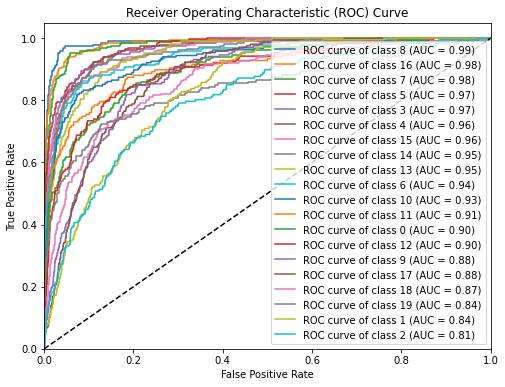

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Ottieni le probabilità predette per ogni classe
y_score = logistic_regression.predict_proba(X_test_norm)

# Calculate the ROC curve and AUC for each class
n_classes = len(np.unique(y))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Sort the classes by AUC in descending order
sorted_classes = sorted(roc_auc.items(), key=lambda x: x[1], reverse=True)

# Plot the ROC curve for each class in descending order of AUC
plt.figure(figsize=(8, 6))
for i, (class_id, auc_value) in enumerate(sorted_classes):
    plt.plot(fpr[class_id], tpr[class_id], label=f'ROC curve of class {class_id} (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# MLP (=Neural Network 1+ hid.layers)

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [8]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (50, 100, 50)],  # Various hidden layer sizes
    'activation': ['logistic', 'tanh', 'relu'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Solvers for optimization
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization parameter
    'learning_rate': ['constant', 'adaptive'],
    'momentum': [0.1, 0.01, 0.001],
    'n_iter_no_change': [20, 30],
    'early_stopping': [True] # Learning rate schedule
}

# Create MLP classifier
mlp = MLPClassifier()

randomized_search = RandomizedSearchCV(mlp, param_grid, n_iter=20, verbose=1, random_state=42, n_jobs=-1)

randomized_search.fit(X_train_norm, y_train)

# Get the best parameter values
best_params = randomized_search.best_params_
print("Best Parameters:", best_params)
print("Best Score:", randomized_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'solver': 'adam', 'n_iter_no_change': 20, 'momentum': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'early_stopping': True, 'alpha': 0.0001, 'activation': 'tanh'}
Best Score: 0.6363238698347657


In [9]:
# Create MLP classifier
mlp = MLPClassifier(**best_params)

mlp.fit(X_train_norm, y_train)

# Make predictions on the test set
y_pred = mlp.predict(X_test_norm)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.6572934973637962
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.58      0.63       186
           1       0.40      0.36      0.38       203
           2       0.37      0.31      0.34       187
           3       0.81      0.80      0.81       196
           4       0.64      0.75      0.69       195
           5       0.86      0.77      0.81       235
           6       0.75      0.78      0.76       196
           7       0.81      0.79      0.80       211
           8       0.81      0.88      0.85       187
           9       0.47      0.50      0.49       204
          10       0.66      0.63      0.64       215
          11       0.54      0.59      0.56       167
          12       0.66      0.62      0.64       173
          13       0.66      0.73      0.70       210
          14       0.69      0.81      0.75       202
          15       0.73      0.74      0.73       218
          16       0.89     

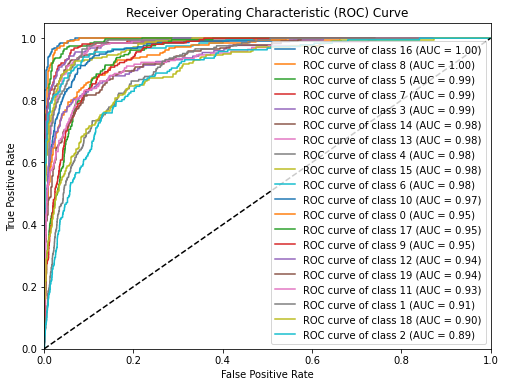

In [12]:

# Get the predicted probabilities for each class
y_score = mlp.predict_proba(X_test_norm)

# Calculate the ROC curve and AUC for each class
n_classes = len(np.unique(y))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Sort the classes by AUC in descending order
sorted_classes = sorted(roc_auc.items(), key=lambda x: x[1], reverse=True)

# Plot the ROC curve for each class in descending order of AUC
plt.figure(figsize=(8, 6))
for i, (class_id, auc_value) in enumerate(sorted_classes):
    plt.plot(fpr[class_id], tpr[class_id], label=f'ROC curve of class {class_id} (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Ensemble learning

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

## Random forests

In [23]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

# Create Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation (cv=5)
grid_search = GridSearchCV(random_forest, param_grid, cv=5)
grid_search.fit(X_train_norm, y_train)

# Get the best parameter values
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.6923220605060799


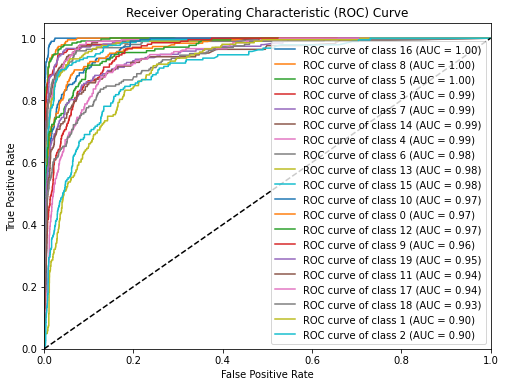

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Get the predicted probabilities for each class
y_score = random_forest.predict_proba(X_test_norm)

# Calculate the ROC curve and AUC for each class
n_classes = len(np.unique(y))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Sort the classes by AUC in descending order
sorted_classes = sorted(roc_auc.items(), key=lambda x: x[1], reverse=True)

# Plot the ROC curve for each class in descending order of AUC
plt.figure(figsize=(8, 6))
for i, (class_id, auc_value) in enumerate(sorted_classes):
    plt.plot(fpr[class_id], tpr[class_id], label=f'ROC curve of class {class_id} (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


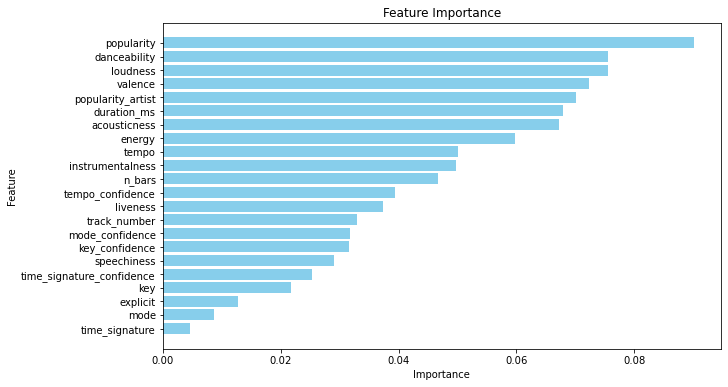

In [15]:
# Get feature importances
feature_importance = random_forest.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display features with the highest importance at the top
plt.show()

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

# Create the Gradient Boosting Machine model
gbm = GradientBoostingClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [300],  # Number of trees
    'max_depth': [5, 7],  # Maximum depth of each tree
    'learning_rate': [0.01, 0.05],  # Learning rate
    'min_samples_split': [5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [3, 5]  # Minimum number of samples required at each leaf node
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=gbm,
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='accuracy',  # Evaluation metric
                           )  

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_norm, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


KeyboardInterrupt: 

In [ ]:
# Create the Gradient Boosting Machine model
gbm = GradientBoostingClassifier(**best_params)
gbm.fit(X_train_norm, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=7, min_samples_leaf=5,
                           min_samples_split=5, n_estimators=300)

In [ ]:
# Make predictions on the test set
y_pred = gbm.predict(X_test_norm)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
accuracy

0.9280597944565556

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1836
           1       0.91      0.92      0.92      1375

    accuracy                           0.93      3211
   macro avg       0.93      0.93      0.93      3211
weighted avg       0.93      0.93      0.93      3211



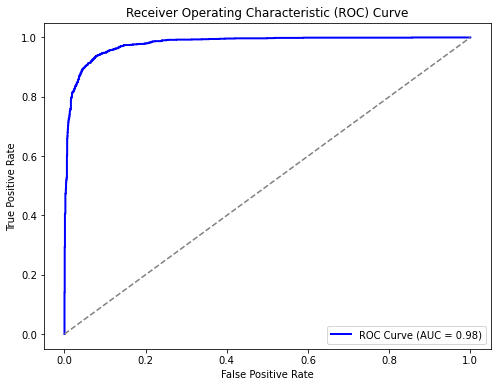

In [ ]:
# Make predictions on the test set
y_pred = gbm.predict(X_test_norm)

# Calculate predicted probabilities for the positive class
y_prob = gbm.predict_proba(X_test_norm)[:, 1]

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Plot feature importance
feature_importance = gbm.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_test.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance (Gradient Boosting Machine)')
plt.show()


NameError: name 'gbm' is not defined